In [96]:
import numpy as np
from scipy import signal
from scipy.fft import fft, fftfreq, irfft, dct, idct
import cv2
import os
import json
import matplotlib.pyplot as plt
%matplotlib inline

import sig_analize as san
import generate_areas as ga
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [103]:
dir_path = './drop-250925-1'
img_path_list = [dir_path + '/'+ f for f in os.listdir(dir_path) if f.endswith('.jpg')]
img_path_list.sort()
img_path_list

['./drop-250925-1/160.jpg',
 './drop-250925-1/180.jpg',
 './drop-250925-1/200.jpg',
 './drop-250925-1/220.jpg',
 './drop-250925-1/240.jpg',
 './drop-250925-1/260.jpg',
 './drop-250925-1/280.jpg']

In [104]:
json_path = 'sequence.txt'

ga.choose_multy(img_path_list, json_path, mode='common')

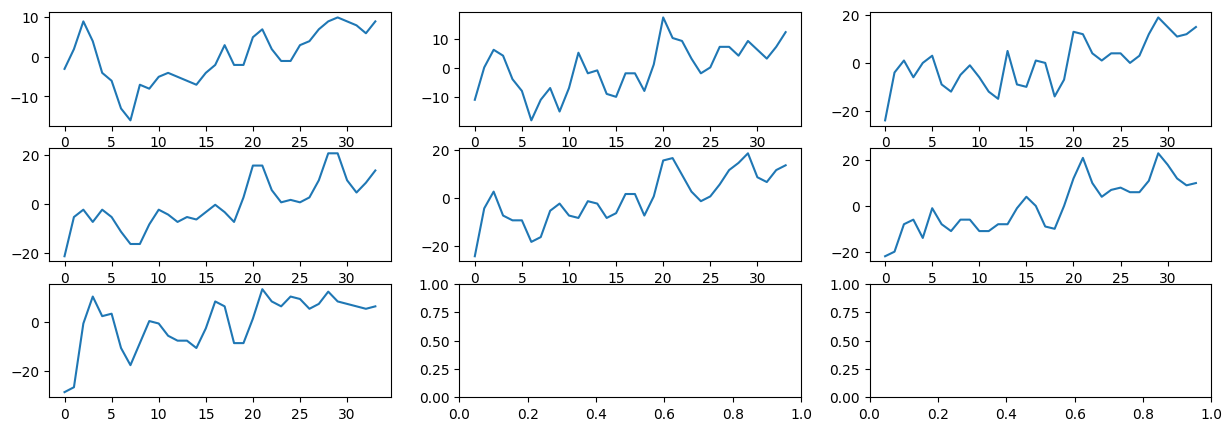

In [110]:
# upload ntencity distributions from json file and
# look at the integral intencity distribution plotted

with open(json_path,'r') as f:
    imgs = json.load(f)[:-1]

img_count = len(imgs)
row_count = (img_count+3-img_count%3)//3

fig, ax = plt.subplots(row_count, 3, figsize=(5*row_count, 5))

for i in range(img_count):
    ax[i//3][i%3].plot(imgs[i])

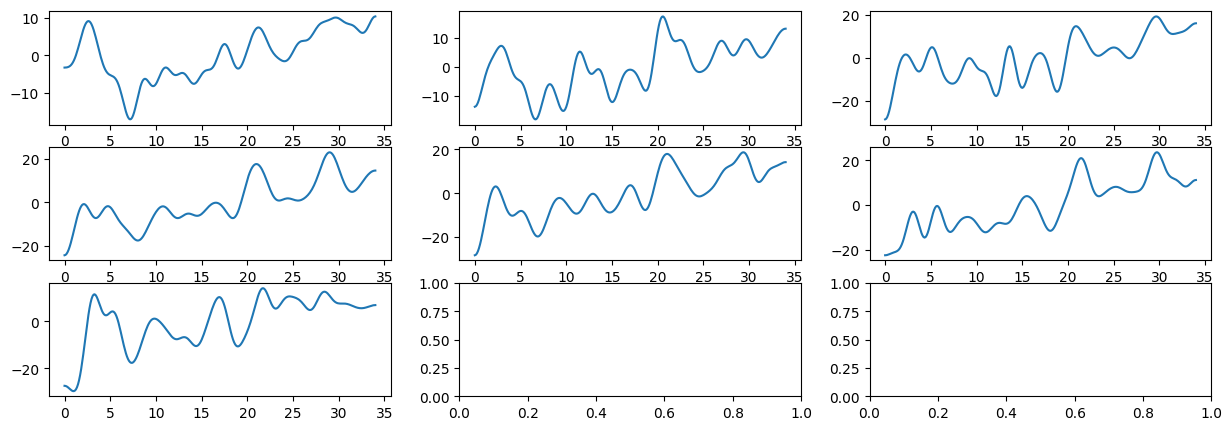

In [111]:
# approximate the graphs with sums of cosinusoids using dct
# and plot the smoother versions 

sig_len = len(imgs[0]) # for mode='commom' length is the same for all signals

N = 300
fs = 0.5*N/sig_len

coeffs = [dct(sig) for sig in imgs]
sig_sm = [san.fourie_restore(coeff, sig_len, fs, N, mode='cos') for coeff in coeffs]

fig, ax = plt.subplots(row_count, 3, figsize=(5*row_count, 5))

for i in range(img_count):
    ax[i//3][i%3].plot(*sig_sm[i])

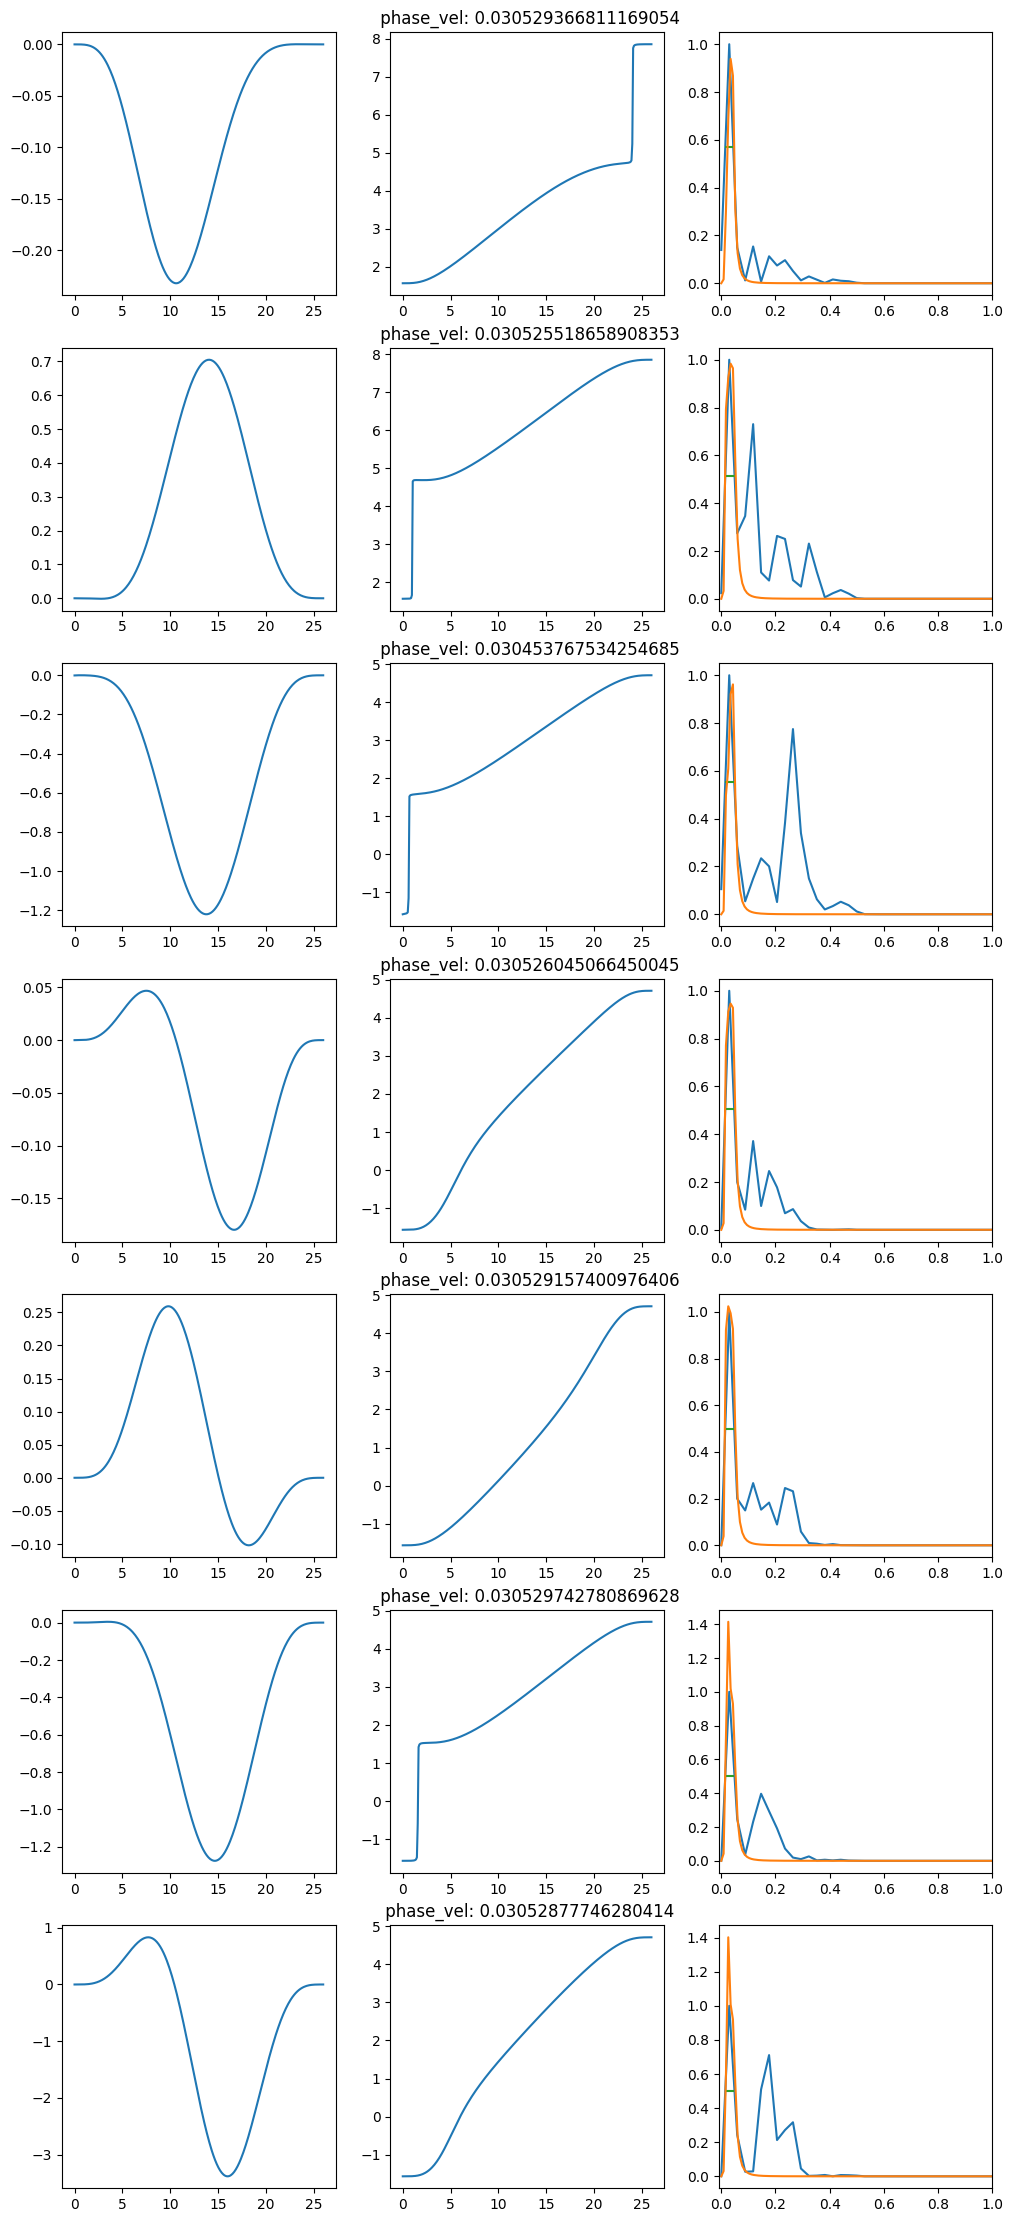

In [113]:
# filtering smoothed signals with san.my_butter
# applying signal.hilbert to the filtered signal 
# plot spectral density destribution and filter responce to monitor

fs = N/sig_len
fs_niq = 0.5*fs

fig, ax = plt.subplots(img_count, 3, figsize=(12,4*img_count))
i = 0

for sig in sig_sm:

    sig_y = sig[1]

    fxx_sm, Pxx_den_sm = signal.welch(np.real(sig_y), fs = fs, nperseg=N) # sampling frequency
    fxx_sm_l = len(fxx_sm)

    den_peak = np.argmax(Pxx_den_sm)
    res = signal.peak_widths(Pxx_den_sm, [den_peak], rel_height=0.5)
    Wn = [res[2]*fs_niq/fxx_sm_l,res[3]*fs_niq/fxx_sm_l]
    
    b, a = sa.my_butter(sig_y, N=4, fs=fs, rel_h=0.5, nperseg=N)# sampling frequency
    w, h = signal.freqz(b, a, fs = fs)
    sig_sm_flt_h = signal.filtfilt(b, a, sig_y, method='gust', irlen=299) 


    ax[i][0].plot(my_sig[0], sig_sm_flt_h)


    anal_y = signal.hilbert(np.real(sig_sm_flt_h))
    instant_phase = np.unwrap(np.angle(anal_y))

    ax[i][1].plot(my_sig[0], instant_phase)
    ax[i][1].set_title(f" phase_vel: {sa.phase_vel(instant_phase[5:-5], dt = 1/fs)}")

    ax[i][2].plot(fxx_sm, Pxx_den_sm/np.max(Pxx_den_sm))
    ax[i][2].hlines(res[1]/np.max(Pxx_den_sm), *Wn, color= 'C2')
    ax[i][2].plot(w, np.abs(h))
    ax[i][2].set_xlim(-0.01, 1)

    i = i+1

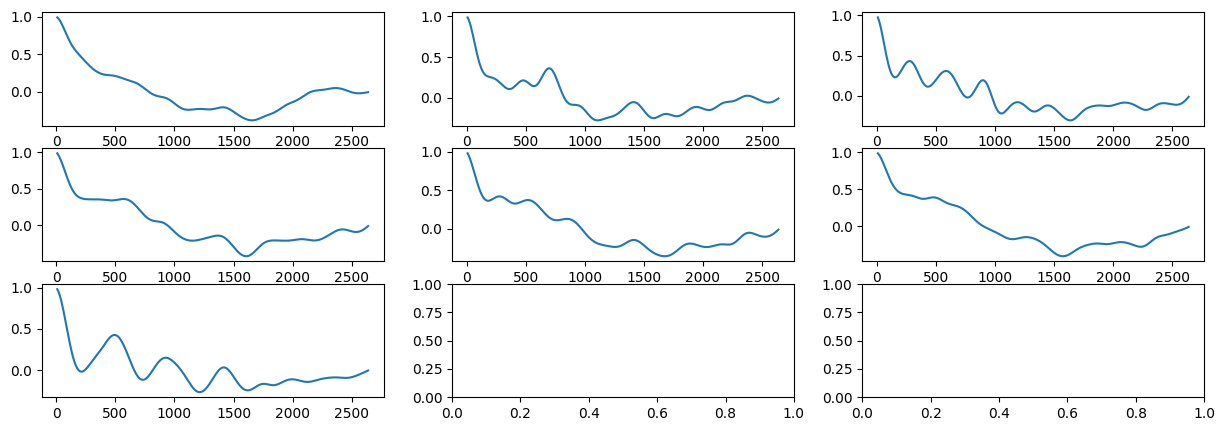

In [120]:
# Let's look at autocorrelation functions of original signals
sig_y = [s[1] for s in sig_sm]

fig, ax = plt.subplots(row_count, 3, figsize=(5*row_count, 5))

for i in range(img_count):
    ax[i//3][i%3].plot(*san.auto_corr(sig_y[i], N, fs))

In [121]:
# to make peaks more prominent it is nesessary to
# remove low frequencies from the signals
# we will use san.my_butter_high to create high pass filter
nl = 2
f_min = nl/sig_len
border = 4

bh, ah = signal.butter(border, f_min, btype = 'highpass', fs=fs)